In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.stem import WordNetLemmatizer
import nltk
from nltk.corpus import stopwords
import re
import tensorflow_datasets as tfds
from tensorflow.keras import layers
from tensorflow.keras import backend as K
import tensorflow_datasets as tfds
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import string
import time


nltk.download('wordnet')
nltk.download('stopwords')


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
df1=pd.read_json("/content/sample_data/Sarcasm_Headlines_Dataset_v2.json",lines=True)
df1=df1[['headline','is_sarcastic']]

In [3]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28619 entries, 0 to 28618
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   headline      28619 non-null  object
 1   is_sarcastic  28619 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 447.3+ KB


In [4]:
df=df1.drop(df1[df1['is_sarcastic']==1].sample(frac=0.10).index)
df=df.reset_index()

In [5]:
df.head()

,index,headline,is_sarcastic
0,0,thirtysomething scientists unveil doomsday clo...,1
1,1,dem rep. totally nails why congress is falling...,0
2,2,eat your veggies: 9 deliciously different recipes,0
3,3,inclement weather prevents liar from getting t...,1
4,4,mother comes pretty close to using word 'strea...,1


In [6]:
df.index

RangeIndex(start=0, stop=27256, step=1)

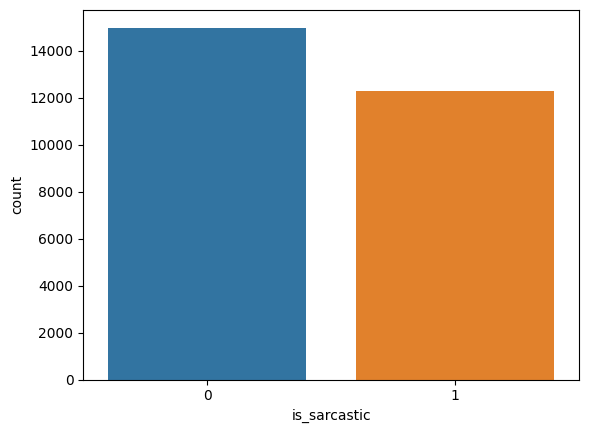

In [7]:
sns.countplot(data=df,x=df.is_sarcastic);

In [8]:
pd.options.display.max_colwidth = 200
pd.DataFrame(df[df['is_sarcastic']==1]['headline']).head(10)

,headline
0,thirtysomething scientists unveil doomsday clock of hair loss
3,inclement weather prevents liar from getting to work
4,mother comes pretty close to using word 'streaming' correctly
7,shadow government getting too large to meet in marriott conference room b
13,ford develops new suv that runs purely on gasoline
15,area boy enters jumping-and-touching-tops-of-doorways phase
16,area man does most of his traveling by gurney
20,guard in video game under strict orders to repeatedly pace same stretch of hallway
31,new york introduces shoe-sharing program for city's pedestrians
33,"expansive obama state of the union speech to touch on patent law, entomology, the films of robert altman"


In [9]:
def decontract(text):
    text = re.sub(r"won\'t", "will not", text)
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s$", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    return text
stopwords_english = set(stopwords.words('english'))-set(['No','no','not','Not'])
def preprocess(text,stopwords=stopwords_english):
    lemmatizer = WordNetLemmatizer()


    # remove stock market tickers like $GE
    text = re.sub(r'\$\w*', '', text)
    # remove old style retweet text "RT"
    text = re.sub(r'^RT[\s]+', '', text)
    # remove hyperlinks
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text)
    #Decontract texts
    text=decontract(text)
    # tokenize texts


    texts_clean = []
    for word in text.split():
        if (word not in stopwords_english and  # remove stopwords
                word not in set(string.punctuation)-set(['!','?','.','@',':'])):  # remove punctuation
            #Lemmatize word
            lem_word = lemmatizer.lemmatize(word,"v")  # Lemmatizing word
            texts_clean.append(lem_word)

    return " ".join(texts_clean)

In [10]:
inputs=list(df['headline'].apply(lambda x: preprocess(x)))
labels=list(df['is_sarcastic'])
X_train, X_test, y_train, y_test = train_test_split(inputs, labels, test_size=0.2)


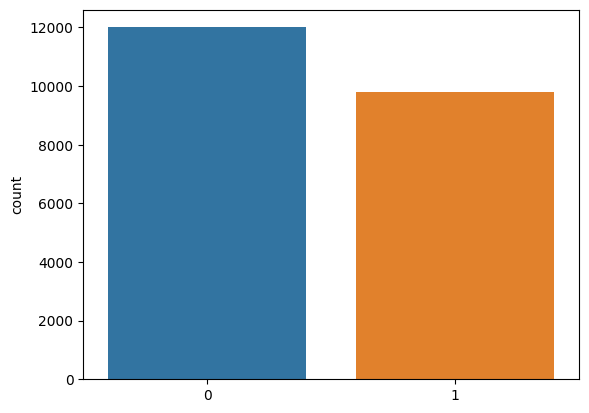

In [11]:
sns.countplot(x=y_train);

In [12]:
def subword_tokenize(train_corpus, vocab_size=2**14, max_length=50,tokenizer=None):
  # Create the vocabulary using Subword tokenization
  if(tokenizer==None):
    tokenizer_corpus = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(train_corpus, target_vocab_size=2**14)
  else:
    tokenizer_corpus=tokenizer
  # Get the final vocab size, adding the eos and sos tokens
  vocab_size = tokenizer_corpus.vocab_size

  # Tokenize the corpus
  sentences = [tokenizer_corpus.encode(sentence) for sentence in train_corpus]

  #Pad the sentences
  sentences = tf.keras.preprocessing.sequence.pad_sequences(sentences,value=0,padding='post',maxlen=50)

  return sentences, tokenizer_corpus, vocab_size

In [13]:
tokenized_inputs,tokenizer,vocab_size=subword_tokenize(train_corpus=X_train)
tokenized_test_inputs,_,vocab_size2=subword_tokenize(X_test,tokenizer=tokenizer)

In [14]:
# Define a dataset
dataset = tf.data.Dataset.from_tensor_slices((tokenized_inputs, y_train))
dataset = dataset.shuffle(len(tokenized_inputs), reshuffle_each_iteration=True).batch(128, drop_remainder=True)

dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [15]:
def scaled_dot_product_attention(queries, keys, values, mask):
    # Calculate the dot product, QK_transpose
    product = tf.matmul(queries, keys, transpose_b=True)
    # Get the scale factor
    keys_dim = tf.cast(tf.shape(keys)[-1], tf.float32)
    # Apply the scale factor to the dot product
    scaled_product = product / tf.math.sqrt(keys_dim)
    # Apply masking when it is requiered
    if mask is not None:
        scaled_product += (mask * -1e9)
    # dot product with Values
    attention = tf.matmul(tf.nn.softmax(scaled_product, axis=-1), values)

    return attention

In [16]:
class MultiHeadAttention(layers.Layer):

    def __init__(self, n_heads):
        super(MultiHeadAttention, self).__init__()
        self.n_heads = n_heads

    def build(self, input_shape):
        self.d_model = input_shape[-1]
        assert self.d_model % self.n_heads == 0
        # Calculate the dimension of every head or projection
        self.d_head = self.d_model // self.n_heads
        # Set the weight matrices for Q, K and V
        self.query_lin = layers.Dense(units=self.d_model)
        self.key_lin = layers.Dense(units=self.d_model)
        self.value_lin = layers.Dense(units=self.d_model)
        # Set the weight matrix for the output of the multi-head attention W0
        self.final_lin = layers.Dense(units=self.d_model)

    def split_proj(self, inputs, batch_size): # inputs: (batch_size, seq_length, d_model)
        # Set the dimension of the projections
        shape = (batch_size,
                 -1,
                 self.n_heads,
                 self.d_head)
        # Split the input vectors
        splited_inputs = tf.reshape(inputs, shape=shape) # (batch_size, seq_length, nb_proj, d_proj)
        return tf.transpose(splited_inputs, perm=[0, 2, 1, 3]) # (batch_size, nb_proj, seq_length, d_proj)

    def call(self, queries, keys, values, mask):
        # Get the batch size
        batch_size = tf.shape(queries)[0]
        # Set the Query, Key and Value matrices
        queries = self.query_lin(queries)
        keys = self.key_lin(keys)
        values = self.value_lin(values)
        # Split Q, K y V between the heads or projections
        queries = self.split_proj(queries, batch_size)
        keys = self.split_proj(keys, batch_size)
        values = self.split_proj(values, batch_size)
        # Apply the scaled dot product
        attention = scaled_dot_product_attention(queries, keys, values, mask)
        # Get the attention scores
        attention = tf.transpose(attention, perm=[0, 2, 1, 3])
        # Concat the h heads or projections
        concat_attention = tf.reshape(attention,
                                      shape=(batch_size, -1, self.d_model))
        # Apply W0 to get the output of the multi-head attention
        outputs = self.final_lin(concat_attention)

        return outputs

In [17]:
class PositionalEncoding(layers.Layer):

    def __init__(self):
        super(PositionalEncoding, self).__init__()

    def get_angles(self, pos, i, d_model): # pos: (seq_length, 1) i: (1, d_model)
        angles = 1 / np.power(10000., (2*(i//2)) / np.float32(d_model))
        return pos * angles # (seq_length, d_model)

    def call(self, inputs):
        # input shape batch_size, seq_length, d_model
        seq_length = inputs.shape.as_list()[-2]
        d_model = inputs.shape.as_list()[-1]
        # Calculate the angles given the input
        angles = self.get_angles(np.arange(seq_length)[:, np.newaxis],
                                 np.arange(d_model)[np.newaxis, :],
                                 d_model)
        # Calculate the positional encodings
        angles[:, 0::2] = np.sin(angles[:, 0::2])
        angles[:, 1::2] = np.cos(angles[:, 1::2])
        # Expand the encodings with a new dimension
        pos_encoding = angles[np.newaxis, ...]

        return inputs + tf.cast(pos_encoding, tf.float32)

In [18]:
class EncoderLayer(layers.Layer):

    def __init__(self, FFN_units, n_heads, dropout_rate):
        super(EncoderLayer, self).__init__()
        # Hidden units of the feed forward component
        self.FFN_units = FFN_units
        # Set the number of projectios or heads
        self.n_heads = n_heads
        # Dropout rate
        self.dropout_rate = dropout_rate

    def build(self, input_shape):
        self.d_model = input_shape[-1]
        # Build the multihead layer
        self.multi_head_attention = MultiHeadAttention(self.n_heads)
        self.dropout_1 = layers.Dropout(rate=self.dropout_rate)
        # Layer Normalization
        self.norm_1 = layers.LayerNormalization(epsilon=1e-6)
        # Fully connected feed forward layer
        self.ffn1_relu = layers.Dense(units=self.FFN_units, activation="relu")
        self.ffn2 = layers.Dense(units=self.d_model)
        self.dropout_2 = layers.Dropout(rate=self.dropout_rate)
        # Layer normalization
        self.norm_2 = layers.LayerNormalization(epsilon=1e-6)

    def call(self, inputs, mask, training):
        # Forward pass of the multi-head attention
        attention = self.multi_head_attention(inputs,
                                              inputs,
                                              inputs,
                                              mask)
        attention = self.dropout_1(attention, training=training)
        # Call to the residual connection and layer normalization
        attention = self.norm_1(attention + inputs)
        # Call to the FC layer
        outputs = self.ffn1_relu(attention)
        outputs = self.ffn2(outputs)
        outputs = self.dropout_2(outputs, training=training)
        # Call to residual connection and the layer normalization
        outputs = self.norm_2(outputs + attention)

        return outputs

In [19]:
class Encoder(layers.Layer):

    def __init__(self,
                 n_layers,
                 FFN_units,
                 n_heads,
                 dropout_rate,
                 vocab_size,
                 d_model,
                 name="encoder"):
        super(Encoder, self).__init__(name=name)
        self.n_layers = n_layers
        self.d_model = d_model
        # The embedding layer
        self.embedding = layers.Embedding(vocab_size, d_model)
        # Positional encoding layer
        self.pos_encoding = PositionalEncoding()
        self.dropout = layers.Dropout(rate=dropout_rate)
        # Stack of n layers of multi-head attention and FC
        self.enc_layers = [EncoderLayer(FFN_units,
                                        n_heads,
                                        dropout_rate)
                           for _ in range(n_layers)]
        self.last_linear = layers.Dense(units=2, name="lin_ouput")

    def call(self, inputs, mask, training):
        # Get the embedding vectors
        outputs = self.embedding(inputs)
        # Scale the embeddings by sqrt of d_model
        outputs *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        # Positional encodding
        outputs = self.pos_encoding(outputs)
        outputs = self.dropout(outputs, training)
        # Call the stacked layers
        for i in range(self.n_layers):
            outputs = self.enc_layers[i](outputs, mask, training)

        logits=tf.math.reduce_mean(outputs,1)
        #print(logits.shape)


        logits=self.last_linear(logits)

        return logits #outputs[:,0:1,:]

In [25]:
def create_padding_mask(seq): #seq: (batch_size, seq_length)
# Create the mask for padding
  mask = tf.cast(tf.math.equal(seq, 0), tf.float32)
  return mask[:, tf.newaxis, tf.newaxis, :]
def loss_function(target, pred):


    return tf.keras.losses.BinaryCrossentropy(from_logits=True)(target,pred)

class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = tf.cast(d_model, tf.float32)
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        step = tf.cast(step, tf.float32)  # 将步骤数显式转换为浮点数类型
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)



In [26]:
def main_train(dataset, encoder, n_epochs, print_every=50):
  ''' Train the transformer model for n_epochs using the data generator dataset'''
  losses = []
  accuracies = []
  # In every epoch
  for epoch in range(n_epochs):
    print("Starting epoch {}".format(epoch+1))
    start = time.time()
    # Reset the losss and accuracy calculations
    train_loss.reset_states()
    train_accuracy.reset_states()
    # Get a batch of inputs and targets
    for (batch, (inputs, targets)) in enumerate(dataset):
        # Set the decoder inputs
        #dec_inputs = targets[:, :-1]
        # Set the target outputs, right shifted
        targets = pd.get_dummies(targets).astype('float').values
        with tf.GradientTape() as tape:
            # Call the transformer and get the predicted output
            predictions = encoder(inputs, create_padding_mask(inputs), True)
            # Calculate the loss
            loss = loss_function(targets, predictions)
        # Update the weights and optimizer
        gradients = tape.gradient(loss, encoder.trainable_variables)
        optimizer.apply_gradients(zip(gradients, encoder.trainable_variables))
        # Save and store the metrics
        train_loss(loss)

        train_accuracy(targets, predictions)

        if batch % print_every == 0:
            losses.append(train_loss.result())
            accuracies.append(train_accuracy.result())
            print("Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}".format(
                epoch+1, batch, train_loss.result(), train_accuracy.result()))

    # Checkpoint the model on every epoch
    #ckpt_save_path = ckpt_manager.save()
    #print("Saving checkpoint for epoch {} in {}".format(epoch+1,ckpt_save_path))
    #print("Time for 1 epoch: {} secs\n".format(time.time() - start))

  return losses, accuracies

In [28]:
tf.keras.backend.clear_session()
# Create the Encoder model
encoder = Encoder(6,512,8,0.1,vocab_size,256)


# Define a metric to store the mean loss of every epoch
train_loss = tf.keras.metrics.Mean(name="train_loss")
# Define a matric to save the accuracy in every epoch
train_accuracy = tf.keras.metrics.BinaryAccuracy(name="train_accuracy")
# Create the scheduler for learning rate decay
leaning_rate = CustomSchedule(256)

# Create the Adam optimizer
optimizer = tf.keras.optimizers.Adam(leaning_rate,
                                     beta_1=0.9,
                                     beta_2=0.98,
                                     epsilon=1e-9)

In [29]:
losses, accuracies = main_train(dataset, encoder, 5)

Starting epoch 1


Epoch 1 Batch 0 Loss 0.7681 Accuracy 0.4961
Epoch 1 Batch 50 Loss 0.7091 Accuracy 0.5105
Epoch 1 Batch 100 Loss 0.6891 Accuracy 0.5299
Epoch 1 Batch 150 Loss 0.6793 Accuracy 0.5450
Starting epoch 2
Epoch 2 Batch 0 Loss 0.6056 Accuracy 0.6367
Epoch 2 Batch 50 Loss 0.5921 Accuracy 0.6646
Epoch 2 Batch 100 Loss 0.5852 Accuracy 0.6708
Epoch 2 Batch 150 Loss 0.5617 Accuracy 0.6907
Starting epoch 3
Epoch 3 Batch 0 Loss 0.4576 Accuracy 0.7930
Epoch 3 Batch 50 Loss 0.4342 Accuracy 0.7916
Epoch 3 Batch 100 Loss 0.4268 Accuracy 0.7943
Epoch 3 Batch 150 Loss 0.4160 Accuracy 0.7999
Starting epoch 4
Epoch 4 Batch 0 Loss 0.3196 Accuracy 0.8555
Epoch 4 Batch 50 Loss 0.3293 Accuracy 0.8536
Epoch 4 Batch 100 Loss 0.3107 Accuracy 0.8608
Epoch 4 Batch 150 Loss 0.3150 Accuracy 0.8585
Starting epoch 5
Epoch 5 Batch 0 Loss 0.1868 Accuracy 0.9414
Epoch 5 Batch 50 Loss 0.2114 Accuracy 0.9127
Epoch 5 Batch 100 Loss 0.2132 Accuracy 0.9115
Epoch 5 Batch 150 Loss 0.2241 Accuracy 0.9058


In [30]:
def predict(encoder,tokenized_sentences):
  logits=encoder(tokenized_sentences,create_padding_mask(tokenized_sentences),False)
  predictions=np.argmax(tf.keras.layers.Softmax()(logits),axis=1)
  return predictions
test_accuracy=sum((predict(encoder,tokenized_test_inputs)==y_test))
test_accuracy/=len(y_test)
print(test_accuracy)
from sklearn.metrics import classification_report
print(classification_report(predict(encoder,tokenized_test_inputs),y_test))

0.811995597945708
              precision    recall  f1-score   support

           0       0.85      0.81      0.83      3126
           1       0.76      0.81      0.79      2326

    accuracy                           0.81      5452
   macro avg       0.81      0.81      0.81      5452
weighted avg       0.81      0.81      0.81      5452



In [31]:
class Encoder(layers.Layer):

    def __init__(self,
                 n_layers,
                 FFN_units,
                 n_heads,
                 dropout_rate,
                 vocab_size,
                 d_model,
                 name="encoder_lstm"):
        super(Encoder, self).__init__(name=name)
        self.n_layers = n_layers
        self.d_model = d_model
        # The embedding layer
        self.embedding = layers.Embedding(vocab_size, d_model)
        # Positional encoding layer
        self.pos_encoding = PositionalEncoding()
        self.dropout = layers.Dropout(rate=dropout_rate)
        # Stack of n layers of multi-head attention and FC
        self.enc_layers = [EncoderLayer(FFN_units,
                                        n_heads,
                                        dropout_rate)
                           for _ in range(n_layers)]
        self.lstm=layers.LSTM(128)
        self.last_linear = layers.Dense(units=2, name="lin_ouput")

    def call(self, inputs, mask, training):
        # Get the embedding vectors
        outputs = self.embedding(inputs)
        # Scale the embeddings by sqrt of d_model
        outputs *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        # Positional encodding
        outputs = self.pos_encoding(outputs)
        outputs = self.dropout(outputs, training)
        # Call the stacked layers
        for i in range(self.n_layers):
            outputs = self.enc_layers[i](outputs, mask, training)

        #logits=tf.math.reduce_mean(outputs,1)
        #print(logits.shape)
        logits=self.lstm(outputs)


        logits=self.last_linear(logits)

        return logits #outputs[:,0:1,:]


tf.keras.backend.clear_session()
# Create the Encoder model
encoder_lstm = Encoder(6,512,8,0.1,vocab_size,256)


# Define a metric to store the mean loss of every epoch
train_loss = tf.keras.metrics.Mean(name="train_loss")
# Define a matric to save the accuracy in every epoch
train_accuracy = tf.keras.metrics.BinaryAccuracy(name="train_accuracy")
# Create the scheduler for learning rate decay
leaning_rate = CustomSchedule(256)
# Create the Adam optimizer
optimizer = tf.keras.optimizers.Adam(leaning_rate,
                                     beta_1=0.9,
                                     beta_2=0.98,
                                     epsilon=1e-9)

losses, accuracies = main_train(dataset, encoder_lstm, 5)

Starting epoch 1
Epoch 1 Batch 0 Loss 0.6813 Accuracy 0.5039
Epoch 1 Batch 50 Loss 0.6922 Accuracy 0.5063
Epoch 1 Batch 100 Loss 0.6877 Accuracy 0.5118
Epoch 1 Batch 150 Loss 0.6793 Accuracy 0.5273
Starting epoch 2
Epoch 2 Batch 0 Loss 0.6602 Accuracy 0.6250
Epoch 2 Batch 50 Loss 0.6147 Accuracy 0.6419
Epoch 2 Batch 100 Loss 0.5874 Accuracy 0.6686
Epoch 2 Batch 150 Loss 0.5719 Accuracy 0.6824
Starting epoch 3
Epoch 3 Batch 0 Loss 0.4393 Accuracy 0.7891
Epoch 3 Batch 50 Loss 0.4272 Accuracy 0.7966
Epoch 3 Batch 100 Loss 0.4210 Accuracy 0.7977
Epoch 3 Batch 150 Loss 0.4164 Accuracy 0.8006
Starting epoch 4
Epoch 4 Batch 0 Loss 0.2495 Accuracy 0.8984
Epoch 4 Batch 50 Loss 0.2949 Accuracy 0.8730
Epoch 4 Batch 100 Loss 0.3066 Accuracy 0.8651
Epoch 4 Batch 150 Loss 0.3120 Accuracy 0.8619
Starting epoch 5
Epoch 5 Batch 0 Loss 0.2681 Accuracy 0.8711
Epoch 5 Batch 50 Loss 0.2262 Accuracy 0.9054
Epoch 5 Batch 100 Loss 0.2300 Accuracy 0.9030
Epoch 5 Batch 150 Loss 0.2349 Accuracy 0.9018


In [32]:
from sklearn.metrics import classification_report
print(classification_report(predict(encoder_lstm,tokenized_test_inputs),y_test))

              precision    recall  f1-score   support

           0       0.79      0.85      0.82      2757
           1       0.83      0.76      0.80      2695

    accuracy                           0.81      5452
   macro avg       0.81      0.81      0.81      5452
weighted avg       0.81      0.81      0.81      5452



In [33]:
class Encoder(layers.Layer):

    def __init__(self,
                 n_layers,
                 FFN_units,
                 n_heads,
                 dropout_rate,
                 vocab_size,
                 d_model,
                 name="encoder_cnn"):
        super(Encoder, self).__init__(name=name)
        self.n_layers = n_layers
        self.d_model = d_model
        # The embedding layer
        self.embedding = layers.Embedding(vocab_size, d_model)
        # Positional encoding layer
        self.pos_encoding = PositionalEncoding()
        self.dropout = layers.Dropout(rate=dropout_rate)
        # Stack of n layers of multi-head attention and FC
        self.enc_layers = [EncoderLayer(FFN_units,
                                        n_heads,
                                        dropout_rate)
                           for _ in range(n_layers)]
        self.cnn=layers.Conv2D(1, (3,3), activation='relu', padding='same', input_shape=(50,256,1))
        self.flatten=layers.Flatten()
        self.last_linear = layers.Dense(units=2, name="lin_ouput")

    def call(self, inputs, mask, training):
        # Get the embedding vectors
        outputs = self.embedding(inputs)
        # Scale the embeddings by sqrt of d_model
        outputs *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        # Positional encodding
        outputs = self.pos_encoding(outputs)
        outputs = self.dropout(outputs, training)
        # Call the stacked layers
        for i in range(self.n_layers):
            outputs = self.enc_layers[i](outputs, mask, training)

        #logits=tf.math.reduce_mean(outputs,1)
        #print(logits.shape)
        logits=K.expand_dims(outputs,axis=-1)
        logits=self.cnn(logits)
        logits=self.flatten(logits)


        logits=self.last_linear(logits)

        return logits #outputs[:,0:1,:]
tf.keras.backend.clear_session()
# Create the Encoder model
encoder_cnn = Encoder(6,512,8,0.1,vocab_size,256)


# Define a metric to store the mean loss of every epoch
train_loss = tf.keras.metrics.Mean(name="train_loss")
# Define a matric to save the accuracy in every epoch
train_accuracy = tf.keras.metrics.BinaryAccuracy(name="train_accuracy")
# Create the scheduler for learning rate decay
leaning_rate = CustomSchedule(256)
# Create the Adam optimizer
optimizer = tf.keras.optimizers.Adam(leaning_rate,
                                     beta_1=0.9,
                                     beta_2=0.98,
                                     epsilon=1e-9)
losses, accuracies = main_train(dataset, encoder_cnn, 4)

Starting epoch 1
Epoch 1 Batch 0 Loss 0.7390 Accuracy 0.4922
Epoch 1 Batch 50 Loss 0.7129 Accuracy 0.5077
Epoch 1 Batch 100 Loss 0.7040 Accuracy 0.5140
Epoch 1 Batch 150 Loss 0.6951 Accuracy 0.5253
Starting epoch 2
Epoch 2 Batch 0 Loss 0.6226 Accuracy 0.6367
Epoch 2 Batch 50 Loss 0.6274 Accuracy 0.6388
Epoch 2 Batch 100 Loss 0.6017 Accuracy 0.6617
Epoch 2 Batch 150 Loss 0.5830 Accuracy 0.6775
Starting epoch 3
Epoch 3 Batch 0 Loss 0.5123 Accuracy 0.7383
Epoch 3 Batch 50 Loss 0.4476 Accuracy 0.7845
Epoch 3 Batch 100 Loss 0.4333 Accuracy 0.7930
Epoch 3 Batch 150 Loss 0.4258 Accuracy 0.7970
Starting epoch 4
Epoch 4 Batch 0 Loss 0.3015 Accuracy 0.8750
Epoch 4 Batch 50 Loss 0.3021 Accuracy 0.8693
Epoch 4 Batch 100 Loss 0.3068 Accuracy 0.8642
Epoch 4 Batch 150 Loss 0.3055 Accuracy 0.8640


In [34]:
losses, accuracies = main_train(dataset, encoder_cnn, 1)

Starting epoch 1
Epoch 1 Batch 0 Loss 0.2268 Accuracy 0.8750
Epoch 1 Batch 50 Loss 0.2248 Accuracy 0.9038
Epoch 1 Batch 100 Loss 0.2370 Accuracy 0.9002
Epoch 1 Batch 150 Loss 0.2348 Accuracy 0.9021


In [35]:
from sklearn.metrics import classification_report
print(classification_report(predict(encoder_cnn,tokenized_test_inputs),y_test))

              precision    recall  f1-score   support

           0       0.87      0.79      0.83      3258
           1       0.73      0.82      0.77      2194

    accuracy                           0.81      5452
   macro avg       0.80      0.81      0.80      5452
weighted avg       0.81      0.81      0.81      5452



In [36]:
examples=['Woman wins award for safe driving','I work forty hours a week for me to be this poor.','I would kill for a Nobel Peace Prize.','Depression is merely anger without enthusiasm.','Two wrongs don’t make a right take your parents as an example .','If I wanted to kill myself I’d climb your ego and jump to your IQ.','Always remember that you are absolutely unique just like everyone else .','Congratulations, If you press the elevator button three times it goes into hurry mode – really...','Hello my name is Raj and I study computer science!','Please get me some fruits from the store .','Want to hang out today ?','Presidency is probably the toughest job around','We should go out and play football','Discounted items end up being the most expensive']

In [37]:
example="Trump's tenure oversaw a massive economic decline , definitely going to vote for him again ."
sentence=tokenizer.encode(preprocess(example))
sentence=tf.keras.preprocessing.sequence.pad_sequences([sentence],value=0,padding='post',maxlen=50)
print(example)
print(predict(encoder,sentence))

Trump's tenure oversaw a massive economic decline , definitely going to vote for him again .
[1]


In [38]:
example="Today is such a beautiful day , the weather is perfect to stay inside ."
sentence=tokenizer.encode(preprocess(example))
sentence=tf.keras.preprocessing.sequence.pad_sequences([sentence],value=0,padding='post',maxlen=50)
print(example)
print(predict(encoder,sentence))

Today is such a beautiful day , the weather is perfect to stay inside .
[1]


In [39]:
#example='Woman wins award for safe driving'
for example in examples:
  sentence=tokenizer.encode(preprocess(example))
  sentence=tf.keras.preprocessing.sequence.pad_sequences([sentence],value=0,padding='post',maxlen=50)
  print(example)
  print(predict(encoder,sentence))
  print(predict(encoder_lstm,sentence))
  print(predict(encoder_cnn,sentence))

Woman wins award for safe driving
[0]
[0]
[0]
I work forty hours a week for me to be this poor.
[1]
[1]
[1]
I would kill for a Nobel Peace Prize.
[1]
[1]
[0]
Depression is merely anger without enthusiasm.
[0]
[1]
[1]
Two wrongs don’t make a right take your parents as an example .
[0]
[0]
[1]
If I wanted to kill myself I’d climb your ego and jump to your IQ.
[0]
[1]
[0]
Always remember that you are absolutely unique just like everyone else .
[0]
[0]
[0]
Congratulations, If you press the elevator button three times it goes into hurry mode – really...
[1]
[1]
[0]
Hello my name is Raj and I study computer science!
[0]
[0]
[0]
Please get me some fruits from the store .
[0]
[0]
[1]
Want to hang out today ?
[0]
[0]
[0]
Presidency is probably the toughest job around
[0]
[0]
[0]
We should go out and play football
[0]
[0]
[0]
Discounted items end up being the most expensive
[1]
[1]
[1]


In [40]:
import os
checkpoint_folder = "ckpt/"
checkpoint_path = os.path.abspath(os.path.join('', checkpoint_folder))

In [41]:
checkpoint_path

'/content/ckpt'

In [42]:
ckpt = tf.train.Checkpoint(encoder=encoder,optimizer=optimizer,)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print("Last checkpoint restored.")

In [43]:
ckpt_save_path = ckpt_manager.save()

In [44]:
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print("Last checkpoint restored.")

Last checkpoint restored.


In [51]:
from sklearn.metrics import roc_auc_score
def predict_proba2(encoder,examples):
    #sentences=[tokenizer.encode(example) for example in examples]
    #sentences=tf.keras.preprocessing.sequence.pad_sequences(sentences,value=0,padding='post',maxlen=50)
    logits=encoder(examples,create_padding_mask(examples),False)
    return layers.Softmax()(logits).numpy()

print(roc_auc_score(y_test, predict_proba2(encoder,tokenized_test_inputs)[:, 1]))


0.8949211402583959


In [52]:

print(roc_auc_score(y_test, predict_proba2(encoder,tokenized_test_inputs)[:, 1]))
print(roc_auc_score(y_test, predict_proba2(encoder_lstm,tokenized_test_inputs)[:, 1]))
print(roc_auc_score(y_test, predict_proba2(encoder_cnn,tokenized_test_inputs)[:, 1]))

0.8949211402583959
0.8982466156477198
0.8920512735936839


In [53]:
print(roc_auc_score(y_test, predict_proba2(encoder_cnn,tokenized_test_inputs)[:, 1]))


0.8920512735936839


In [51]:
encoder=Encoder()